In [1]:
import sys
import importlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.distributions as dist

sys.path.append("..")
from src import utils, models
importlib.reload(utils)
importlib.reload(models)

<module 'src.models' from '/home/jhaberbe/Projects/Personal/ate/notebook/../src/models.py'>

In [60]:
import scanpy as sc
adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
adata = adata[adata.obs["folder"].eq("05-27")]
adata = adata[adata.layers["transcript"].sum(axis=1) > 20]

/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Data Setup

In [62]:
import torch
import wandb
import torch.distributions as dist

# Data Setup
data = utils.generate_torch_geometric_data(adata)
data.counts = torch.tensor(adata.layers["transcript"], dtype=torch.float32)
data.near_amyloid = torch.tensor(adata.obs["near_amyloid"].values, dtype=torch.float32)
data.lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values, dtype=torch.float32)
data.total_counts = torch.tensor(adata.layers["transcript"].sum(axis=1))
data.size_factors = utils.counts_to_size_factors(data.total_counts)
data.cell_type_encoded = torch.tensor(pd.get_dummies(adata.obs["cell_type"].cat.codes).astype(float).values)

category_mapping = {cat: code for code, cat in enumerate(adata.obs["cell_type"].cat.categories)}
category_mapping

# Model Setup
nb_model = models.JointEmbeddingGATv2NBNet(len(category_mapping), 64, 64, data.x.shape[1])

# Send to proper devices.
device = "cuda"
data.to(device)
nb_model.to(device)

# Training routine.
optimizer = torch.optim.Adam(nb_model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 2_000

In [109]:
wandb.init(project="ate", name="gatv2_nb_training")

for epoch in range(num_epochs):
    nb_model.train()
    optimizer.zero_grad()

    logits, dispersion = nb_model(
        data.cell_type_encoded.int(), 
        data.lipid_droplet_area, 
        data.edge_index
    )

    nb_dist = dist.NegativeBinomial(
        logits=logits + data.size_factors.repeat(logits.shape[1], 1).T,
        total_count=dispersion
    )
    log_likelihood = nb_dist.log_prob(data.counts).sum(axis=1).mean()
    loss = -log_likelihood
    loss.backward()
    optimizer.step()
    wandb.log({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})
    if epoch % 100 == 0:
        print({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇██
log_likelihood,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,2000
log_likelihood,-158.69774
loss,158.69774


{'epoch': 1, 'loss': 158.69679260253906, 'log_likelihood': -158.69679260253906}
{'epoch': 101, 'loss': 158.6080780029297, 'log_likelihood': -158.6080780029297}
{'epoch': 201, 'loss': 158.52264404296875, 'log_likelihood': -158.52264404296875}
{'epoch': 301, 'loss': 158.44049072265625, 'log_likelihood': -158.44049072265625}
{'epoch': 401, 'loss': 158.3619842529297, 'log_likelihood': -158.3619842529297}
{'epoch': 501, 'loss': 158.28530883789062, 'log_likelihood': -158.28530883789062}
{'epoch': 601, 'loss': 158.21139526367188, 'log_likelihood': -158.21139526367188}
{'epoch': 701, 'loss': 158.13986206054688, 'log_likelihood': -158.13986206054688}
{'epoch': 801, 'loss': 158.07040405273438, 'log_likelihood': -158.07040405273438}
{'epoch': 901, 'loss': 158.00335693359375, 'log_likelihood': -158.00335693359375}
{'epoch': 1001, 'loss': 157.93719482421875, 'log_likelihood': -157.93719482421875}
{'epoch': 1101, 'loss': 157.87266540527344, 'log_likelihood': -157.87266540527344}
{'epoch': 1201, 'los

In [110]:
torch.save(nb_model.state_dict(), "../models/gatv2_nb_model.pth")
nb_model.load_state_dict(torch.load("../models/gatv2_nb_model.pth"))

<All keys matched successfully>

# Example of Treatment Effect
- For example, what is the expected effect of lipid droplets, conditioned on the neighborhood.

In [111]:
indices = np.arange(adata.shape[0])[
    adata.obs["cell_type"].eq("L2/3 IT") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
]

In [ ]:
nb_model.to(device)

results = {}

for idx in tqdm(indices):
    x_clone = data.x.clone()
    lipid_droplet_area_clone = data.lipid_droplet_area.clone()
    lipid_droplet_area_clone[idx] = 0.0
    nb_model.eval()
    with torch.no_grad():
        logits, dispersion = nb_model(
            data.cell_type_encoded.int(), 
            data.lipid_droplet_area, 
            data.edge_index
        )

        results[idx] = logits[idx].cpu().detach()

treatment = pd.DataFrame(
    results, 
    index=adata.var_names
).T

logits, _ = nb_model(
    data.cell_type_encoded.int(), 
    data.lipid_droplet_area > 0, 
    data.edge_index
)

null = pd.DataFrame(
    logits[treatment.index].cpu().detach().numpy(), 
    index=treatment.index, 
    columns=adata.var_names
)

100%|██████████| 1999/1999 [00:09<00:00, 209.27it/s]


# Visualization

Could probably be done with gaussian processes.
- Maybe the output linear layer could be done with GPs too!

P2RY12    -0.179193
RNF144B   -0.129956
TMEM119   -0.129608
PAX6      -0.121121
ITGAX     -0.113151
LYPD6     -0.103724
HS3ST4    -0.084816
CASP7     -0.078261
AQP4      -0.071796
ST18      -0.069945
GPNMB     -0.069625
ETV6      -0.066284
RGS10     -0.058816
NLRP3     -0.052757
PLIN5     -0.048878
CD3G      -0.048738
ABCC9     -0.047057
RFTN1     -0.043629
CD36      -0.041876
SULF1     -0.041708
MKI67     -0.040164
CERCAM    -0.039504
PCSK6     -0.039370
GNLY      -0.027599
CPT1B     -0.026506
FGF1      -0.021119
PLD5      -0.019117
MAG       -0.013824
IL7R      -0.010939
IGFBP3     0.004567
EFHD1      0.005736
SOX9       0.006682
GALC       0.010237
TOP2A      0.017306
NWD2       0.020898
CENPF      0.024910
LOX        0.028166
ABCG4      0.035930
POU6F2     0.042796
DNER       0.050165
TPH2       0.110680
dtype: float64

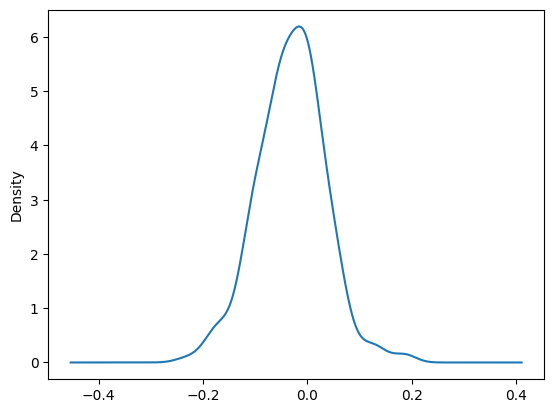

In [165]:
mean_area = np.log1p(adata[
    adata.obs["cell_type"].eq("L2/3 IT") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
].obs["lipid_droplet_area"])

expressed = (adata[
    adata.obs["cell_type"].eq("L2/3 IT") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
].layers["transcript"] > 1).mean(axis=0) > .3

(treatment - null).div(mean_area.tolist(), axis=0).mean(axis=0).plot.kde()
(treatment - null).div(mean_area.tolist(), axis=0).mean(axis=0).sort_values()[expressed]

<Axes: xlabel='mean_area', ylabel='TPH2'>

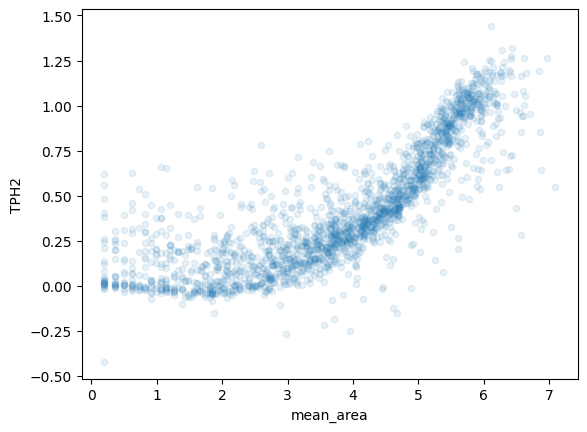

In [166]:
(treatment - null).assign(mean_area = mean_area.tolist()).plot.scatter(
    x="mean_area",
    y="TPH2",
    alpha = 0.1
)

# Changes cell type in the neighborhood.

In [126]:
category_mapping

{'Pvalb': 0,
 'L4 IT': 1,
 'Oligodendrocyte': 2,
 'L2/3 IT': 3,
 'Astrocyte': 4,
 'Endothelial': 5,
 'Sst': 6,
 'Microglia-PVM': 7,
 'VLMC': 8,
 'VIP': 9,
 'Macrophage': 10,
 'OPC': 11,
 'L6b': 12}

In [298]:
import torch
from tqdm import tqdm
import random
import pandas as pd

import torch
import random
import numpy as np
import pandas as pd
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

def perform_neighbor_perturbation(
        adata,
        data,
        cell_type_testing,
        cell_type_perturb,
        category_mapping,
        nb_model
    ):

    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type_testing) 
        & 
        adata.obs["lipid_droplet_area"].gt(0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]

    nb_model.to(device)
    results = {}
    target_cell_type = category_mapping[cell_type_perturb]

    # full edge index
    edge_index = data.edge_index

    for idx in indices:
        # extract 2-hop subgraph
        subset, sub_edge_index, mapping, _ = k_hop_subgraph(
            torch.tensor([idx]), 
            num_hops=2, 
            edge_index=edge_index, 
            relabel_nodes=True
        )

        # remap everything to local subgraph
        cell_type_clone = data.cell_type_encoded[subset].clone()
        lipid_droplet_area = data.lipid_droplet_area[subset]

        center_idx = mapping.item()  # local index of target cell
        num_nodes = len(subset)

        # Find neighbors within the subgraph (1-hop)
        neighbors = sub_edge_index[1][sub_edge_index[0] == center_idx].tolist()
        if not neighbors:
            continue  # skip if isolated

        chosen_neighbor = random.choice(neighbors)
        i = 0
        while (cell_type_clone[chosen_neighbor].argmax() == target_cell_type) and i < 10:
            chosen_neighbor = random.choice(neighbors)
            i += 1

        # Replace cell type
        cell_type_clone[chosen_neighbor][cell_type_clone[chosen_neighbor].argmax()] = 0
        cell_type_clone[chosen_neighbor][target_cell_type] = 1

        # Run model on subgraph
        nb_model.eval()
        with torch.no_grad():
            logits, _ = nb_model(
                cell_type_clone.int().to(device),
                lipid_droplet_area.to(device),
                sub_edge_index.to(device)
            )

        results[idx] = logits[center_idx].cpu().detach()

    # Compile treatment effect
    treatment = pd.DataFrame(results, index=adata.var_names).T

    # Null model using full graph
    logits, _ = nb_model(
        data.cell_type_encoded.int().to(device), 
        data.lipid_droplet_area.to(device), 
        data.edge_index.to(device)
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return treatment - null


pairwise_testing = {
    cell_type: {
        cell_type_perturb: perform_neighbor_perturbation(adata, data, cell_type, cell_type_perturb, category_mapping, nb_model)
        for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
    }
    for cell_type in tqdm(adata.obs["cell_type"].unique())
}

100%|██████████| 13/13 [03:07<00:00, 14.46s/it]


In [471]:
outcomes = []

for cell_type in adata.obs["cell_type"].unique():
    mean_expression = pd.Series(
        adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0),
        index=adata.var_names
    )

    for cell_type_perturb, average_treatment_effect in pairwise_testing[cell_type].items():
        if average_treatment_effect.shape[0] > 200:
            aggregate = {
                "cell_type": cell_type,
                "cell_type_perturb": cell_type_perturb,
                "effect":  (average_treatment_effect.mean(axis=0))[mean_expression > 0.5].abs().sum(), 
            }
            per_gene = {
                gene: (average_treatment_effect[gene].mean() if (mean_expression.loc[gene] > 0.5) else None)
                for gene in average_treatment_effect.columns
            }
            aggregate.update(per_gene)
            outcomes.append(aggregate)


<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

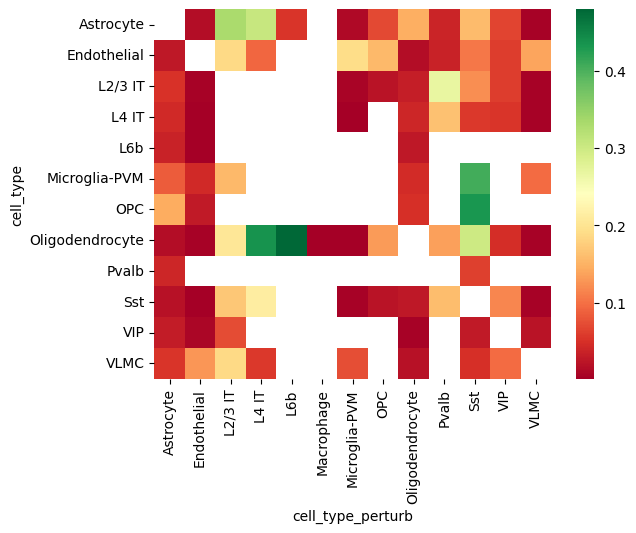

In [472]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(index="cell_type", columns="cell_type_perturb", values="effect")
sns.heatmap(heatmap, cmap="RdYlGn")

<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

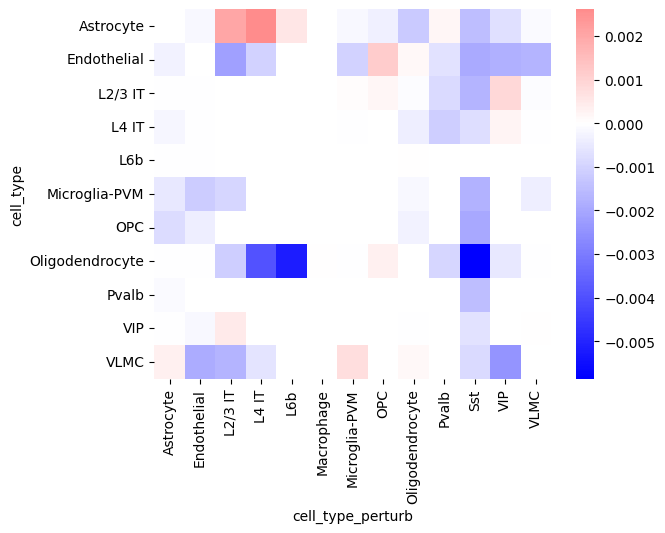

In [486]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(
    index="cell_type", 
    columns="cell_type_perturb", 
    values="LAMP1"
)
sns.heatmap(heatmap, cmap="bwr", center=0)

# What's the effect of inducing lipid droplet changes in a cell.

- Suppose we want to see what the effect is on a cell if we change the amount of lipid in its' neighboring cells, where will the effect be strongest.

In [489]:
import torch
import random
import numpy as np
import pandas as pd
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

def perform_neighbor_perturbation(
    adata, 
    data, 
    cell_type_testing, 
    cell_type_perturb, 
    category_mapping,
    new_lipid_value=0.0, 
    min_lipid_size=4.0
):
    # Todo: adjust so that we can add new bounds, question addition vs removal of lipid droplet.
    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type_testing) 
        & 
        adata.obs["lipid_droplet_area"].gt(0.0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]


    nb_model.to(device)
    results = {}
    target_cell_type = category_mapping[cell_type_perturb]
    edge_index = data.edge_index

    for idx in indices:
        # extract 2-hop subgraph
        subset, sub_edge_index, mapping, _ = k_hop_subgraph(
            torch.tensor([idx]), 
            num_hops=2, 
            edge_index=edge_index, 
            relabel_nodes=True
        )

        # Get subgraph feature tensors
        cell_type_clone = data.cell_type_encoded[subset].clone()
        lipid_droplet_area = data.lipid_droplet_area[subset].clone()

        center_idx = mapping.item()  # local index of target cell

        # Find matching cell type in subgraph (excluding the target)
        candidate_indices = [
            i for i in range(len(subset))
            if ((i != center_idx) & (cell_type_clone[i].argmax().item() == target_cell_type) & (lipid_droplet_area[i] > min_lipid_size))
        ]

        if not candidate_indices:
            continue  # skip if no perturbable cell found

        chosen_perturb_idx = random.choice(candidate_indices)

        # Replace lipid droplet value of that cell
        lipid_droplet_area[chosen_perturb_idx] = new_lipid_value

        # Run model on subgraph
        nb_model.eval()
        with torch.no_grad():
            logits, _ = nb_model(
                cell_type_clone.int().to(device),
                lipid_droplet_area.to(device),
                sub_edge_index.to(device)
            )

        results[idx] = logits[center_idx].cpu().detach()

    # Compile treatment effect
    treatment = pd.DataFrame(results, index=adata.var_names).T

    # Null model using full graph
    logits, _ = nb_model(
        data.cell_type_encoded.int().to(device), 
        data.lipid_droplet_area.to(device), 
        data.edge_index.to(device)
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return treatment - null

pairwise_testing = {
    cell_type: {
        cell_type_perturb: perform_neighbor_perturbation(
            adata, 
            data, 
            cell_type, 
            cell_type_perturb, 
            category_mapping,
            new_lipid_value=0.0
        )
        for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
    }
    for cell_type in tqdm(adata.obs["cell_type"].unique())
}

100%|██████████| 13/13 [05:29<00:00, 25.32s/it]


In [490]:
outcomes = []

for cell_type in adata.obs["cell_type"].unique():
    mean_expression = pd.Series(
        adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0),
        index=adata.var_names
    )

    for cell_type_perturb, average_treatment_effect in pairwise_testing[cell_type].items():
        if average_treatment_effect.shape[0] > 200:
            aggregate = {
                "cell_type": cell_type,
                "cell_type_perturb": cell_type_perturb,
                "effect":  (mean_expression * average_treatment_effect.mean(axis=0)).abs().sum(), 
            }
            per_gene = {
                gene: (average_treatment_effect[gene].mean() if mean_expression.loc[gene] > .5 else 0)
                for gene in average_treatment_effect.columns
            }
            aggregate.update(per_gene)
            outcomes.append(aggregate)

<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

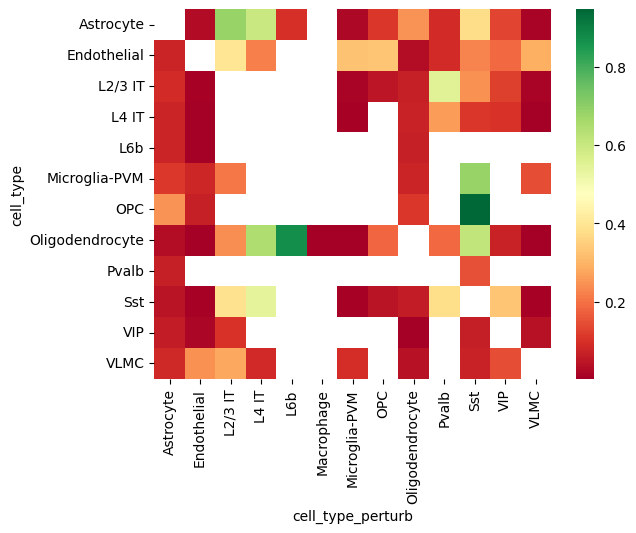

In [491]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(index="cell_type", columns="cell_type_perturb", values="effect")
sns.heatmap(heatmap, cmap="RdYlGn")

In [522]:
pd.DataFrame(outcomes).sort_values(["APOE"])

,cell_type,cell_type_perturb,effect,ABCC9,ABCG4,ACAT1,ACAT2,ACSL1,ACSL3,ACSL4,...,TSHZ2,TTYH1,UGT8,UNC5B,VCAN,VIP,VWC2L,WIF1,ZBBX,ZDHHC23
19,Astrocyte,L4 IT,0.599681,0.0,0,0,0,0.000000,0.009295,0,...,0.0,-0.001613,0.0,0,0.0,0.0,0,0,0,0
16,Astrocyte,L2/3 IT,0.684647,0.0,0,0,0,0.000000,0.008846,0,...,0.0,-0.006023,0.0,0,0.0,0.0,0,0,0,0
9,Sst,L4 IT,0.539542,0.0,0,0,0,0.000000,0.010095,0,...,0.0,0.000000,0.0,0,0.0,0.0,0,0,0,0
10,Astrocyte,Sst,0.378957,0.0,0,0,0,0.000000,0.001870,0,...,0.0,0.000431,0.0,0,0.0,0.0,0,0,0,0
29,Microglia-PVM,Sst,0.683624,0.0,0,0,0,-0.020631,0.000000,0,...,0.0,0.000000,0.0,0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,Sst,L2/3 IT,0.387605,0.0,0,0,0,0.000000,0.006020,0,...,0.0,0.000000,0.0,0,0.0,0.0,0,0,0,0
7,Sst,Oligodendrocyte,0.059297,0.0,0,0,0,0.000000,-0.000076,0,...,0.0,0.000000,0.0,0,0.0,0.0,0,0,0,0
8,Sst,Pvalb,0.381771,0.0,0,0,0,0.000000,0.004493,0,...,0.0,0.000000,0.0,0,0.0,0.0,0,0,0,0
15,Astrocyte,OPC,0.109465,0.0,0,0,0,0.000000,-0.000632,0,...,0.0,0.002187,0.0,0,0.0,0.0,0,0,0,0
